In [68]:
using Random

In [69]:
include("../rollout.jl")

simulate_trajectory (generic function with 1 method)

In [70]:
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Issues
- Use control variates to see how they affect the rollout acquisition functions

In [71]:
MAX_SGD_ITERS = 250
BATCH_SIZE = 64
HORIZON = 0
MC_SAMPLES = 25
BUDGET = 1
NUM_TRIALS = 1
OBJECTIVE = "ei" == "ei" ? :EI : :LOGEI

:EI

In [72]:
# Setup toy problem
testfn = TestRosenbrock()
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]
fbest = testfn.f(first(testfn.xopt))

# Get NUM_TRIALS initial samples
initial_samples = randsample(NUM_TRIALS, testfn.dim, lbs, ubs)

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);

# Surrogate hyperparameters and initial setup
θ, output_var, σn2 = [1.], 1., 1e-4
ψ = kernel_scale(kernel_matern52, [output_var, θ...]);

# Generate batch of locations to perform SGA on
batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs)
gaps = zeros(NUM_TRIALS, BUDGET+2) # +2 for initial gap and row index
gaps[:, 1] = cumsum(ones(NUM_TRIALS));

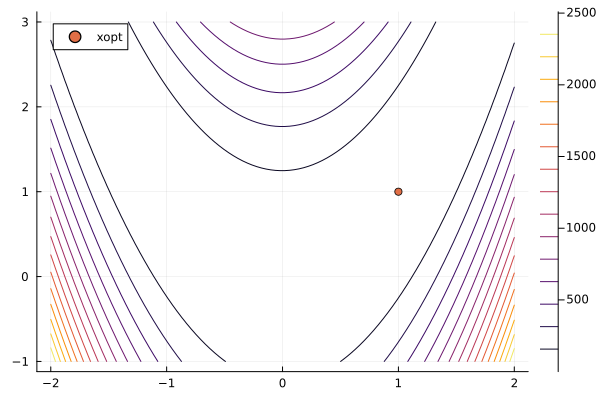

In [73]:
tplot(testfn)

In [74]:
X = reshape(initial_samples[:, 1], testfn.dim, 1)
sur = fit_surrogate(ψ, X, testfn.f; σn2=σn2) # (TODO): Learn kernel hyperparameters

println("Beginning Bayesian Optimization Main Loop")
println("-----------------------------------------")
for budget in 1:BUDGET
    println("\nIteration #$budget")
    # Optimize each batch location in parallel
    results = []

    for j = 1:size(batch, 2)
        x0 = batch[:, j]

        res = stochastic_gradient_ascent_adam(x0;
            max_sgd_iters=MAX_SGD_ITERS, lbs=lbs, ubs=ubs, mc_iters=MC_SAMPLES,
            lds_rns=lds_rns, horizon=HORIZON, sur=sur, gtol=1e-10, ftol=1e-8, max_counter=10
        )
        push!(results, res)
    end

    if length(results) == 0
        start = finish = rand(testfn.dim) .* (ubs - lbs) + lbs
        push!(results, (start=start, finish=finish, final_obj=nothing, final_grad=nothing, iters=0, success=true))
    end
    
    for r in results
        println(r)
    end

    # Update surrogate with element that optimize the acquisition function
    max_ndx = findmax(t -> t.final_obj, results)[2]
    max_pairing = results[max_ndx]
    xnew = max_pairing.finish
    native_y = recover_y(sur)

    sur = fit_surrogate(ψ, hcat(sur.X, xnew), vcat(native_y, testfn.f(xnew)); σn2=σn2)
    res = optimize_hypers_optim(sur, kernel_matern52; σn2=σn2)
    σ, ℓ = Optim.minimizer(res)
    global ψ = kernel_scale(kernel_matern52, [σ, ℓ])
    native_y = recover_y(sur)
    sur = fit_surrogate(ψ, sur.X, native_y; σn2=σn2)
end # END Bayesian Optimization Loop
println("-----------------------------------------")

# Update collective data
# gaps[trial, 2:end] = measure_gap(sur, fbest)
println("\nObservations: $(sur.y) -- True Best: $fbest")

Beginning Bayesian Optimization Main Loop
-----------------------------------------

Iteration #1
(start = [0.0, 1.0], finish = [-0.5837622845574594, 2.31506259733483], final_obj = 279.39059300405864, final_grad = [-2.006274506377475e-6, 1.27730470670239e-6], iters = 250, success = true)
(start = [1.0, 0.0], finish = [0.2676338422276055, -0.6422350244690976], final_obj = 279.3881520804834, final_grad = [-1.8003782964054584e-5, -2.376637433154166e-5], iters = 250, success = true)
(start = [-1.0, 2.0], finish = [-1.550644852554255, 2.5848051112962445], final_obj = 279.39131635781587, final_grad = [-3.570272266591619e-9, 1.8634789160060908e-9], iters = 250, success = true)
(start = [-0.5, 0.5], finish = [-1.087753053176334, -0.21061154559297643], final_obj = 279.3911378143087, final_grad = [-1.9174973982061421e-7, -8.871901062865147e-8], iters = 250, success = true)
(start = [1.5, 2.5], finish = [0.2527220802733468, 3.0], final_obj = 279.39015167452266, final_grad = [-2.3877220734988376e-

In [76]:
sur.X

2×2 Matrix{Float64}:
 1.63003   -1.98591
 0.988138   2.89085

In [77]:
sur.y

2-element Vector{Float64}:
  79.5574674428135
 -79.5574674428135

In [90]:
x0 = [0., 0.]
simulate_trajectory(sur;
    mc_iters=MC_SAMPLES, rnstream=lds_rns, ubs=ubs, lbs=lbs, x0=x0,
    h=HORIZON, objective=:logEI
)

LoadError: SingularException(2)

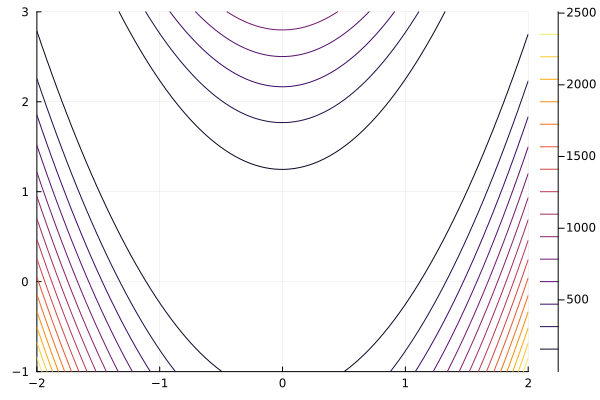

In [80]:
xx = range(-2.0, 2.0, length=100)
yy = range(-1.0, 3.0, length=100)

plot(xx, yy, (x,y) -> testfn([x,y]), st=:contour)

In [101]:
sur(sur.X[:,1] .+ 1).EI

0.0

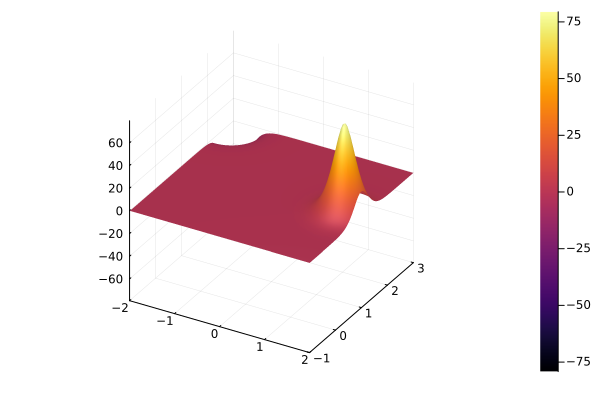

In [82]:
plot(xx, yy, (x,y) -> sur([x,y]).μ, st=:surface)

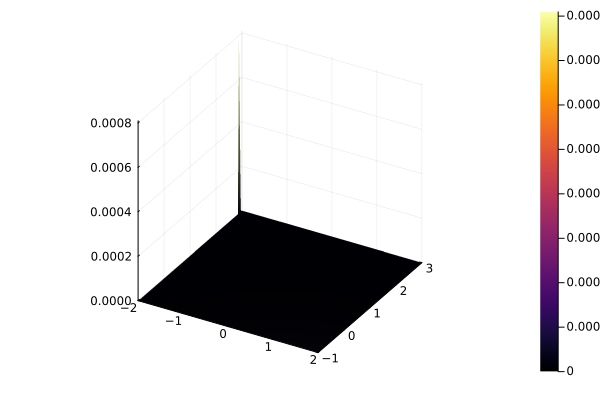

In [102]:
plot(xx, yy, (x,y) -> sur([x,y]).EI, st=:surface)